# Explaining Moving Averages 

Moving Averages are basically applied to stationary datasets for forecasting. This notebook explains the different methods to calculate moving averages for a given dataset. (part-3 of [Time Series Modelling and Analysis tutorial](https://www.youtube.com/playlist?list=PL3N9eeOlCrP5cK0QRQxeJd6GrQvhAtpBK))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Lets load the electricity consumption dataset. This data consists of 6 columns namely:
'Bill_Date','On_peak', 'Off_peak', 'Usage_charge', 'Billed_amount', 'Billing_days'.  
Since the column 'Bill_Date' is of object format, let's use a datetime parser to convert it.

In [2]:
from datetime import datetime

def convert_datetime(x):
    return datetime.strptime(x, '%m/%d/%Y')

data = pd.read_csv('electricity_consumption.csv', parse_dates = ['Bill_Date'], date_parser = convert_datetime)

In [3]:
data.head()

,Bill_Date,On_peak,Off_peak,Usage_charge,Billed_amount,Billing_days
0,2016-01-01,365,1423.5,219.0,247.73,31
1,2016-02-01,292,1138.8,175.2,234.11,31
2,2016-03-01,130,507.0,78.0,123.85,29
3,2016-04-01,117,456.3,70.2,111.22,29
4,2016-05-01,136,530.4,81.6,118.37,29


In [4]:
print('Rows: {}'.format(data.shape[0]))
print('Columns: {}'.format(data.shape[1]))
print('\nMissing Values:\n{}'.format(data.isna().any()))

Rows: 53
Columns: 6

Missing Values:
Bill_Date        False
On_peak          False
Off_peak         False
Usage_charge     False
Billed_amount    False
Billing_days     False
dtype: bool


here we are interested in only Bill_Date and Billed_amount.

In [5]:
df = data[['Bill_Date', 'Billed_amount']]
df = df.set_index('Bill_Date')

In [6]:
df.head()

,Billed_amount
Bill_Date,
2016-01-01,247.73
2016-02-01,234.11
2016-03-01,123.85
2016-04-01,111.22
2016-05-01,118.37


### Moving Averages for forecasting

##### Case 1: Simple moving Average

SMA = (t + (t-1) + (t-2) + ... + (t-n)) / n  
where t is the time instant, t-n are the lag periods for n = 1,2..  
In pandas, SMA is implemented using the rolling window method where n is the window value!

In [7]:
df['sma'] = df['Billed_amount'].rolling(window = 3).mean().shift(1) #first shift for the forecasting!

In [8]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 8)

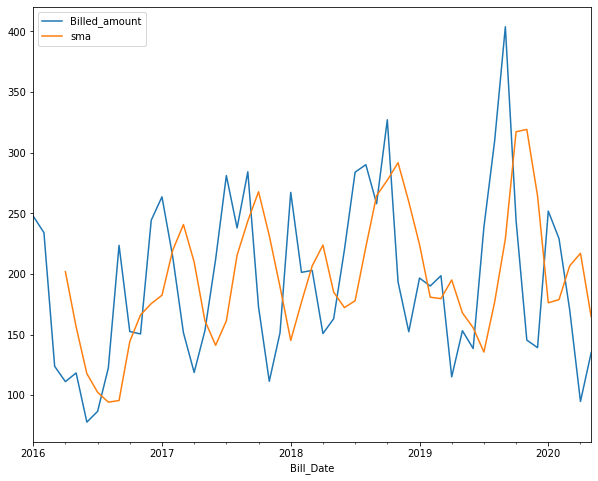

In [9]:
df.plot()

###### Insight:
    -SMA is suitable for complete stationary data, it's pretty flat. hence it doesnt capture any surges.
    -SMA captured the seasonality with a time lag!

##### Case 2: Weighted moving Average

WMA = (t * w) + ((t-1) * w - 1) +...+ ((t-n) * w- n)/n  
where w = random weight assigned by the user. If the weight is greater then model stresses on the recent datapoints and lesser weight to previous ones

In [10]:
def wma(weights): 
    "Simple function implementing the WMA formula"
    def calc(x):
        return (weights*x).mean()
    return calc

In [11]:
df['wma'] = df['Billed_amount'].rolling(window = 3).apply(wma(np.array([0.5,1,1.5]))).shift(1)

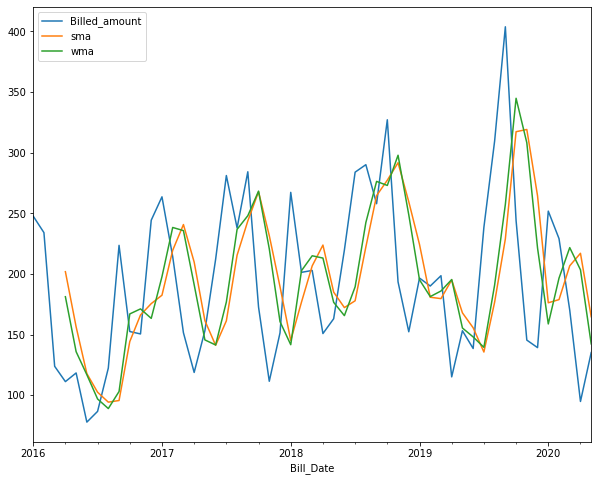

In [12]:
df.plot()

###### Insight:
    WMA is comparatively better in capturing the surges. It is much closer to actual value than the SMA.
    The only disadvantage is to assign the weights manually!

##### Case 3: Exponential moving average 
EMA = (actual - previous EMA) * (2/(span+1)) + previous EMA

EMA adopts more quickly to data trend than the other two! (No need to decide the weights like how we did in WMA)

In [13]:
df['ema'] = df['Billed_amount'].ewm(span = 3, adjust = False, min_periods = 3).mean().shift(1) #3 day exponential moving average

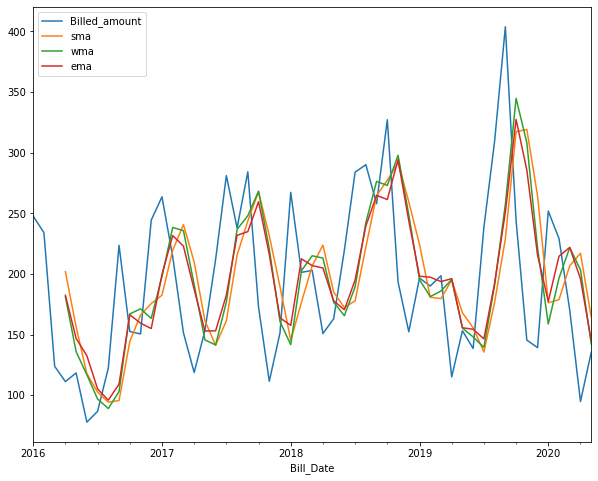

In [14]:
df.plot()

###### Insight:
    There are certain cases where the EMA is closer to actual data point

##### Case 4: Exponential smoothing average

ESA: 
    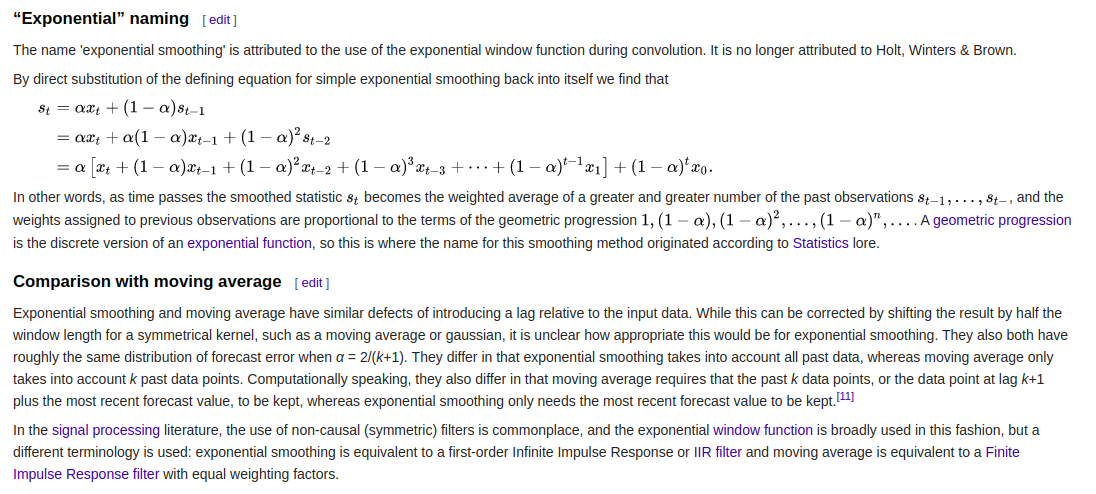

In [15]:
df['esa_alpha_0.7'] = df['Billed_amount'].ewm(alpha = 0.7, adjust = False, min_periods = 3).mean().shift(1)

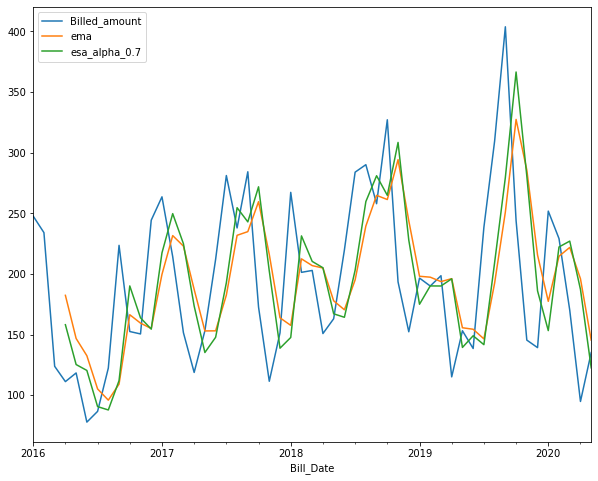

In [16]:
df[['Billed_amount', 'ema','esa_alpha_0.7']].plot()

###### Insight:
    As seen from the graph, explonential smoothing captures almost all the surges in the dataset. There are cases when the ESA is more closer to actual data than the EMA.

In [17]:
df['esa_alpha_0.3'] = df['Billed_amount'].ewm(alpha = 0.3, adjust = False, min_periods = 3).mean().shift(1)

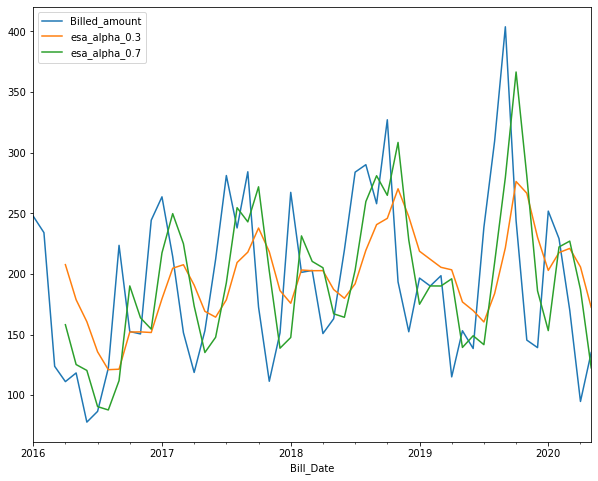

In [18]:
df[['Billed_amount', 'esa_alpha_0.3', 'esa_alpha_0.7']].plot()

###### Insight:
    As alpha increases, the attention is towards the recent datapoint (captures all surges and seasonality!)
    As alpha decreases, history is taken into account and the curve is more smoother!

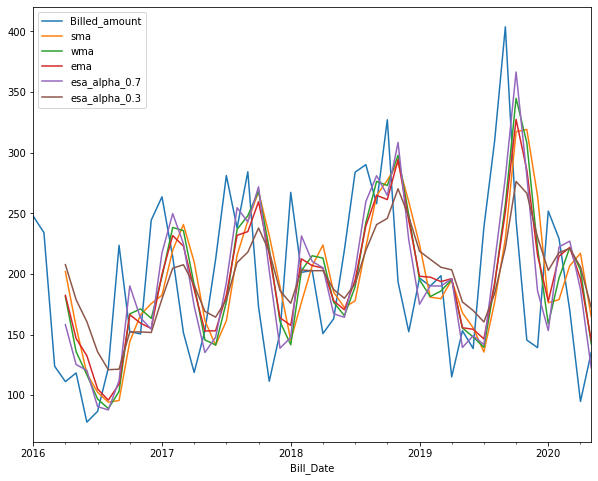

In [19]:
# Putting all the graphs together
df.plot()

### Which Model is good for forecasting??

Among the models covered, let's find the root mean square error and check which one is best suited for the given dataset.

In [20]:
def rmse(pred, df):
    # function to calculate the rmse
    return (((df['Billed_amount'] - df[pred]) ** 2).mean()**0.5)

In [21]:
# Let's look at the dataframe again
df

,Billed_amount,sma,wma,ema,esa_alpha_0.7,esa_alpha_0.3
Bill_Date,,,,,,
2016-01-01,247.73,NaN,NaN,NaN,NaN,NaN
2016-02-01,234.11,NaN,NaN,NaN,NaN,NaN
2016-03-01,123.85,NaN,NaN,NaN,NaN,NaN
2016-04-01,111.22,201.896667,181.250000,182.385000,158.153800,207.705800
2016-05-01,118.37,156.393333,135.911667,146.802500,125.300140,178.760060
2016-06-01,77.81,117.813333,116.900000,132.586250,120.449042,160.643042
2016-07-01,86.67,102.466667,96.898333,105.198125,90.601713,135.793129
2016-08-01,122.40,94.283333,89.000000,95.934063,87.849514,121.056191
2016-09-01,223.62,95.626667,103.058333,109.167031,112.034854,121.459333


In [22]:
df.columns

Index(['Billed_amount', 'sma', 'wma', 'ema', 'esa_alpha_0.7', 'esa_alpha_0.3'], dtype='object')

In [23]:
print('RMSE of Simple Moving Average: {}'.format(rmse('sma', df)))

RMSE of Simple Moving Average: 78.72717946455623


In [24]:
print('RMSE of Weighted Moving Average: {}'.format(rmse('wma', df)))

RMSE of Weighted Moving Average: 72.4925892561133


In [25]:
print('RMSE of Exponential Moving Average: {}'.format(rmse('ema', df)))

RMSE of Exponential Moving Average: 68.49910906881522


In [26]:
print('RMSE of Exponential Smoothing Average (alpha - 0.7): {}'.format(rmse('esa_alpha_0.7', df)))

RMSE of Exponential Smoothing Average (alpha - 0.7): 66.83253524231748


In [27]:
print('RMSE of Exponential Smoothing Average (alpha - 0.3): {}'.format(rmse('esa_alpha_0.3', df)))

RMSE of Exponential Smoothing Average (alpha - 0.3): 70.5301174049304


        This ESA with alpha = 0.7 is the best model for forecasting!